In [1]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 입력으로 들어온 token단어들에 대해서 lemmatization 어근 변환. 
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# TfidfVectorizer 객체 생성 시 tokenizer인자로 해당 함수를 설정하여 lemmatization 적용
# 입력으로 문장을 받아서 stop words 제거-> 소문자 변환 -> 단어 토큰화 -> lemmatization 어근 변환. 
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [2]:
# 문서 군집화 적용
import pandas as pd
import glob, os
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 700)

path = r'C:\Users\silve\pythonML\ch08/topics'
all_files = glob.glob(os.path.join(path, "*.data"))
filename_list = [] # 개별 파일들의 파일명
opinion_text = [] # 개별 파일들의 파일내용

for file_ in all_files:
    # 개별 파일 읽어서 DataFrame으로 생성
    df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    # 절대경로로 주어진 파일명 가공, .data 확장자 제거
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    
    filename_list.append(filename)
    opinion_text.append(df.to_string())
    
# 파일명, 파일 내용 리스트를 DataFrame으로 생성
document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english', \
                            ngram_range=(1,2), min_df=0.05, max_df=0.85)

# opnion_text 칼럼값으로 feature vectorization 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

# 3개 집합으로 군집화 수행
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label']=cluster_label

호텔을 주제로 군집화 된 문서를 이용해 문서 간의 유사도 측정<br>
각 문서 피처 벡처화된 데이터를 cosine_similarity()로 상호 비교

In [3]:
# 호텔 주제 군집화 문서 추출
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=2인 데이터는 호텔로 군집화된 데이터. DataFrame에서 해당 인덱스 추출
hotel_indexes = document_df[document_df['cluster_label']==2].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index', hotel_indexes)

# 호텔로 군집화된 데이터 중 첫 번째 문서를 추출해 파일명 표시
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명 ', comparison_docname, '와 타 문서 유사도 #####')

'''document_df에서 추출한 Index 객체를 feature_vect로 입력해 호텔 군집화된 feature_vect 추출
이를 이용해 호텔로 군집화된 문서 중 첫 번째 문서와 다른 문서 간의 코사인 유사도 측청'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 클러스터링 된 문서들의 DataFrame Index Int64Index([ 0,  2,  3,  4,  5,  8,  9, 10, 11, 12, 19, 23, 26, 27, 33, 34, 35,
            36, 41, 42, 43, 44, 48, 49, 50],
           dtype='int64')
##### 비교 기준 문서명  accuracy_garmin_nuvi_255W_gps 와 타 문서 유사도 #####
[[1.         0.03004155 0.0399055  0.03321949 0.01659167 0.34657949
  0.19665144 0.03271487 0.03613626 0.01828703 0.02061394 0.0511192
  0.03626147 0.01762981 0.10104874 0.15598296 0.03667107 0.03388559
  0.03301419 0.02971984 0.20146574 0.02735475 0.18343275 0.01715513
  0.12148216]]


가장 유사도가 큰 파일명 및 유사도:
 filename      directions_garmin_nuvi_255W_gps
similarity                           0.346579
Name: 8, dtype: object


Text(0.5, 1.0, 'accuracy_garmin_nuvi_255W_gps')

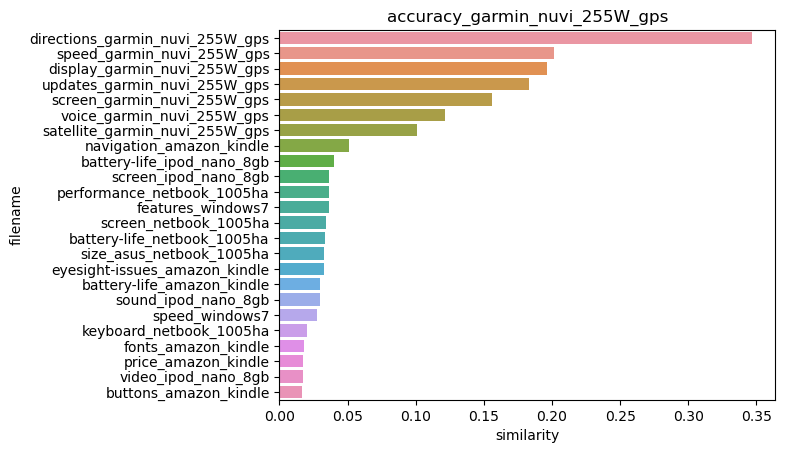

In [4]:
# 시각화
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 추출하되 자기 자신 제외
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:,1:]

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재정렬
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유삳 값 재정렬, 자기 자신 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도값을 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value
print('가장 유사도가 큰 파일명 및 유사도:\n', hotel_1_sim_df.iloc[0, :])

sns.barplot(x='similarity', y='filename', data = hotel_1_sim_df)
plt.title(comparison_docname)